In [124]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.results import Results
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials, select_trials
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
seed=1997

In [125]:
def compute_mean(data,st,end):
        if np.all(np.isnan(data)):
            return np.nan
        return np.nanmean(data[:, st:end] * 1000, axis=1)

In [126]:
def get_fr_info(neu: NeuronData, start_sample, end_sample, start_test, end_test):
    res = {}
    res["nid"] = neu.get_neuron_id()
    samples = [11, 15, 51, 55, 0]
    for loc in ["in", "out"]:
        mask = getattr(neu, "mask_son_" + loc)
        # Sample on: get att and avg response
        sp_son = getattr(neu, "sp_son_" + loc)
        time_before_son = getattr(neu, "time_before_son_" + loc)
        idx_start_sample = time_before_son + start_sample
        idx_end_sample = time_before_son + end_sample
        fr_son = firing_rate.moving_average(data=sp_son, win=100, step=1)[
            :, idx_start_sample:idx_end_sample
        ]
        # Test 1 on: get att and avg response
        sp_t1on = getattr(neu, "sp_t1on_" + loc)
        time_before_t1on = getattr(neu, "time_before_t1on_" + loc)
        idx_start_test = time_before_t1on + start_test
        idx_end_test = time_before_t1on + end_test
        fr_ton = firing_rate.moving_average(data=sp_t1on, win=100, step=1)[
            :, idx_start_test:idx_end_test
        ]
        # Sample on: group trial by orientation and color
        sample_id = neu.sample_id[mask]
        son_oc = select_trials.get_sp_by_sample(fr_son, sample_id, samples)
        son_o1 = np.concatenate((son_oc["11"], son_oc["15"]))
        son_o5 = np.concatenate((son_oc["51"], son_oc["55"]))
        son_c1 = np.concatenate((son_oc["11"], son_oc["51"]))
        son_c5 = np.concatenate((son_oc["15"], son_oc["55"]))
        # Test 1 on: group trial by orientation and color
        t1on_oc = select_trials.get_sp_by_sample(fr_ton, sample_id, samples)
        t1on_o1 = np.concatenate((t1on_oc["11"], t1on_oc["15"]))
        t1on_o5 = np.concatenate((t1on_oc["51"], t1on_oc["55"]))
        t1on_c1 = np.concatenate((t1on_oc["11"], t1on_oc["51"]))
        t1on_c5 = np.concatenate((t1on_oc["15"], t1on_oc["55"]))
        # define idx
        sonst = np.abs(start_sample)
        soned = sonst + 450
        d1st = soned
        d1ed = d1st + 400
        d2ed = 400



        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)

            # mean fr by color/orientation
            res[f"son_c1_{loc}"] = compute_mean(son_c1, sonst,soned)
            res[f"son_c5_{loc}"] = compute_mean(son_c5, sonst,soned)
            res[f"son_o1_{loc}"] = compute_mean(son_o1, sonst,soned)
            res[f"son_o5_{loc}"] = compute_mean(son_c5, sonst,soned)
            res[f"d1_c1_{loc}"] = compute_mean(son_c1, d1st,d1ed)
            res[f"d1_c5_{loc}"] = compute_mean(son_c5, d1st,d1ed)
            res[f"d1_o1_{loc}"] = compute_mean(son_o1, d1st,d1ed)
            res[f"d1_o5_{loc}"] = compute_mean(son_o5, d1st,d1ed)
            res[f"d2_c1_{loc}"] = compute_mean(t1on_c1, 0,d2ed)
            res[f"d2_c5_{loc}"] = compute_mean(t1on_c5, 0,d2ed)
            res[f"d2_o1_{loc}"] = compute_mean(t1on_o1, 0,d2ed)
            res[f"d2_o5_{loc}"] = compute_mean(t1on_o5, 0,d2ed)
            # mean fr by sample
            res[f"son_o1c1_{loc}"] = compute_mean(son_oc["11"], sonst,soned)
            res[f"son_o1c5_{loc}"] = compute_mean(son_oc["15"], sonst,soned)
            res[f"son_o5c1_{loc}"] = compute_mean(son_oc["51"], sonst,soned)
            res[f"son_o5c5_{loc}"] = compute_mean(son_oc["55"], sonst,soned)
            res[f"son_n_{loc}"] = compute_mean(son_oc["0"], sonst,soned)
            res[f"d1_o1c1_{loc}"] = compute_mean(son_oc["11"], d1st,d1ed)
            res[f"d1_o1c5_{loc}"] = compute_mean(son_oc["15"], d1st,d1ed)
            res[f"d1_o5c1_{loc}"] = compute_mean(son_oc["51"], d1st,d1ed)
            res[f"d1_o5c5_{loc}"] = compute_mean(son_oc["55"], d1st,d1ed)
            res[f"d1_n_{loc}"] = compute_mean(son_oc["0"], d1st,d1ed)
            res[f"d2_o1c1_{loc}"] = compute_mean(t1on_oc["11"], 0,d2ed)
            res[f"d2_o1c5_{loc}"] = compute_mean(t1on_oc["15"], 0,d2ed)
            res[f"d2_o5c1_{loc}"] = compute_mean(t1on_oc["51"], 0,d2ed)
            res[f"d2_o5c5_{loc}"] = compute_mean(t1on_oc["55"], 0,d2ed)
            res[f"d2_n_{loc}"] = compute_mean(t1on_oc["0"], 0,d2ed)

    return res

In [127]:
def compute_epochs_fr(preprocessing: Dict, paths: Dict):
    print("Reading population data")
    popu = PopulationData.from_python_hdf5(paths["input"])

    print("Computing selectivity")
    df_fr = popu.execute_function(get_fr_info, **preprocessing, n_jobs=-1, ret_df=True)
    return df_fr

In [20]:
area='lip'
paths= {  'input': f"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/{area}/2024_08_28_12_23_36/population.h5"}
preprocessing={
  'start_sample': -200,
  'end_sample': 850,
  'start_test': -400,
  'end_test': 500}

In [21]:
popu = PopulationData.from_python_hdf5(paths["input"])

In [22]:
get_fr_info(popu.population[275],**preprocessing)

{'nid': 'mua7LIP2023-11-23_10-54-38Riesling',
 'son_c1_in': array([ 4.08888889,  7.84444444, 17.55555556, 13.04444444, 10.53333333,
        13.68888889,  6.71111111,  4.44444444, 15.        ,  7.88888889,
        16.73333333, 11.2       ,  7.2       ,  6.66666667,  4.35555556,
        20.71111111, 11.13333333, 10.        , 18.51111111,  7.11111111,
         7.57777778, 19.75555556, 11.24444444, 18.53333333,  4.44444444,
         8.57777778,  8.44444444, 14.02222222,  3.48888889, 12.        ,
         7.64444444,  6.66666667,  4.44444444, 15.86666667,  4.44444444,
         6.37777778,  9.91111111, 13.91111111,  9.97777778, 13.46666667,
         4.44444444, 13.77777778, 15.71111111, 12.44444444,  0.        ,
         4.44444444,  0.        ,  0.        ,  0.        ,  2.22222222,
         2.22222222,  0.        ,  4.44444444,  2.24444444,  0.        ,
         2.22222222,  4.44444444,  0.        ,  6.66666667,  4.44444444,
        20.31111111,  8.42222222, 18.68888889, 15.13333333, 28.82

### Plot results

In [128]:
save=True
save_format='jpg'
path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/epochs_fr/2024_09_17_12_35_08'
save_no_neutral_inout_selectivity=True
df_fr_all={}
for area in ['v4']:
    df_fr_all[area]=pd.read_pickle(f"{path}/{area}/population_epochs_fr.pkl")

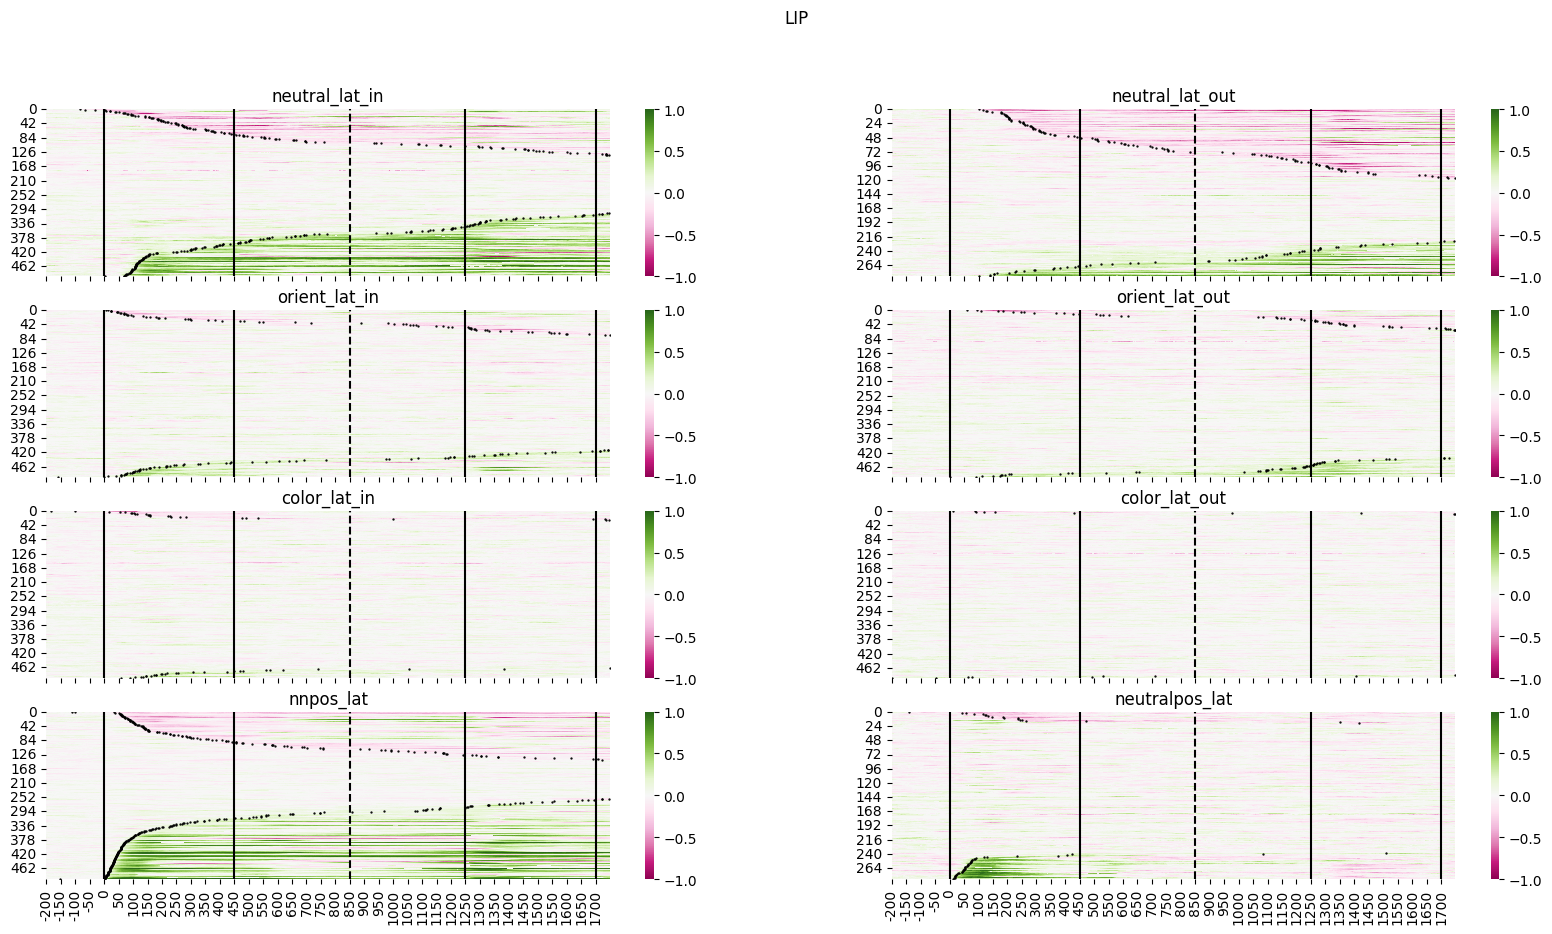

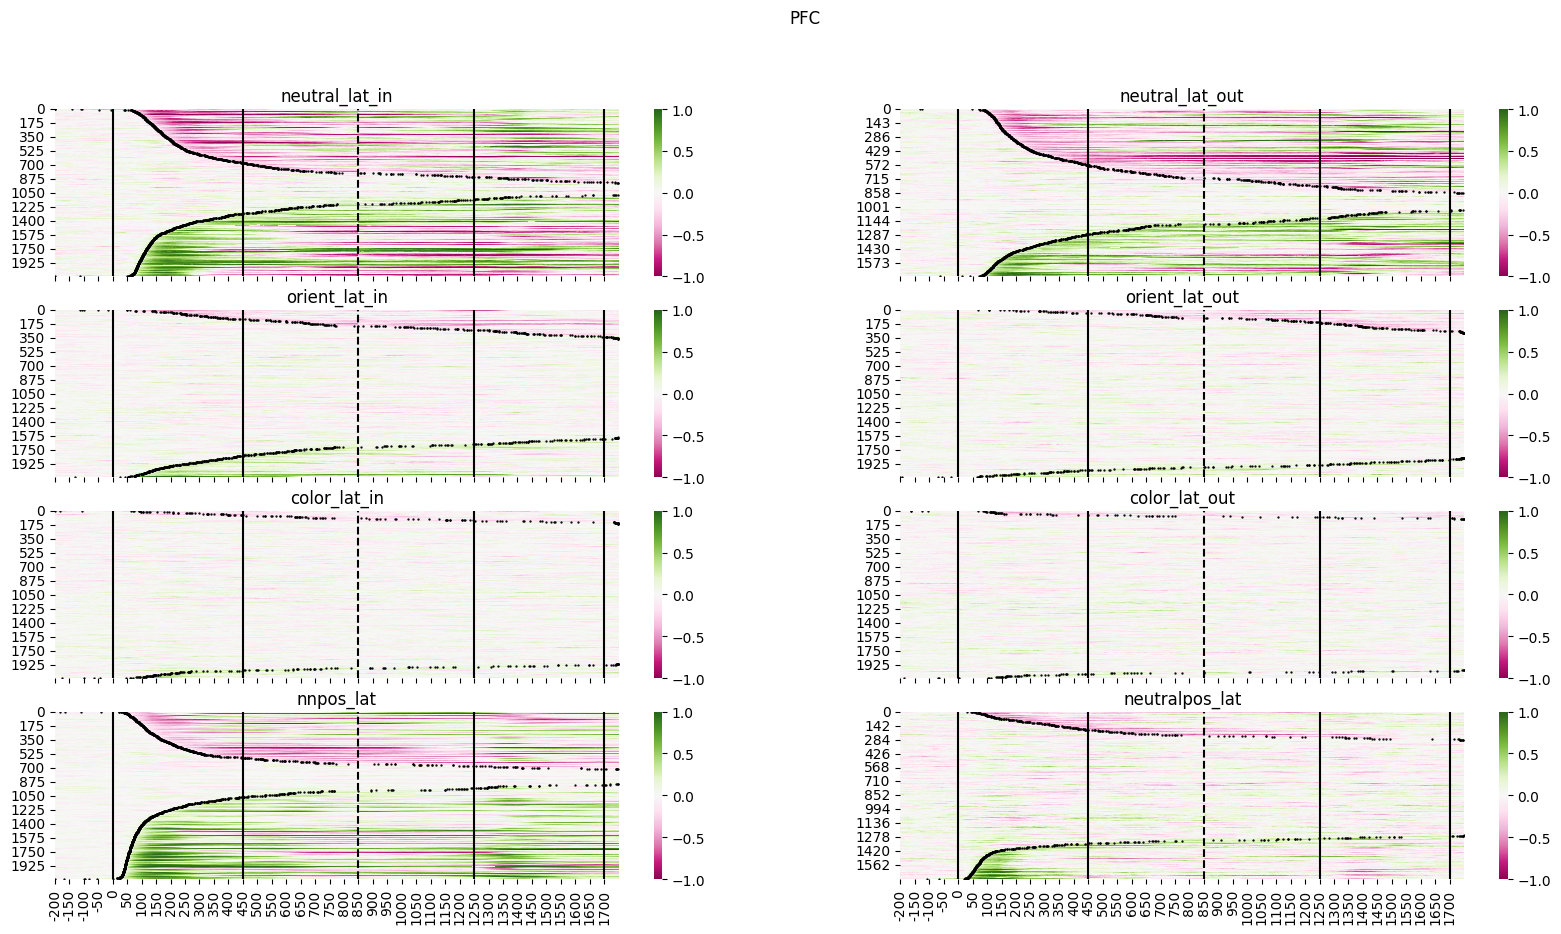

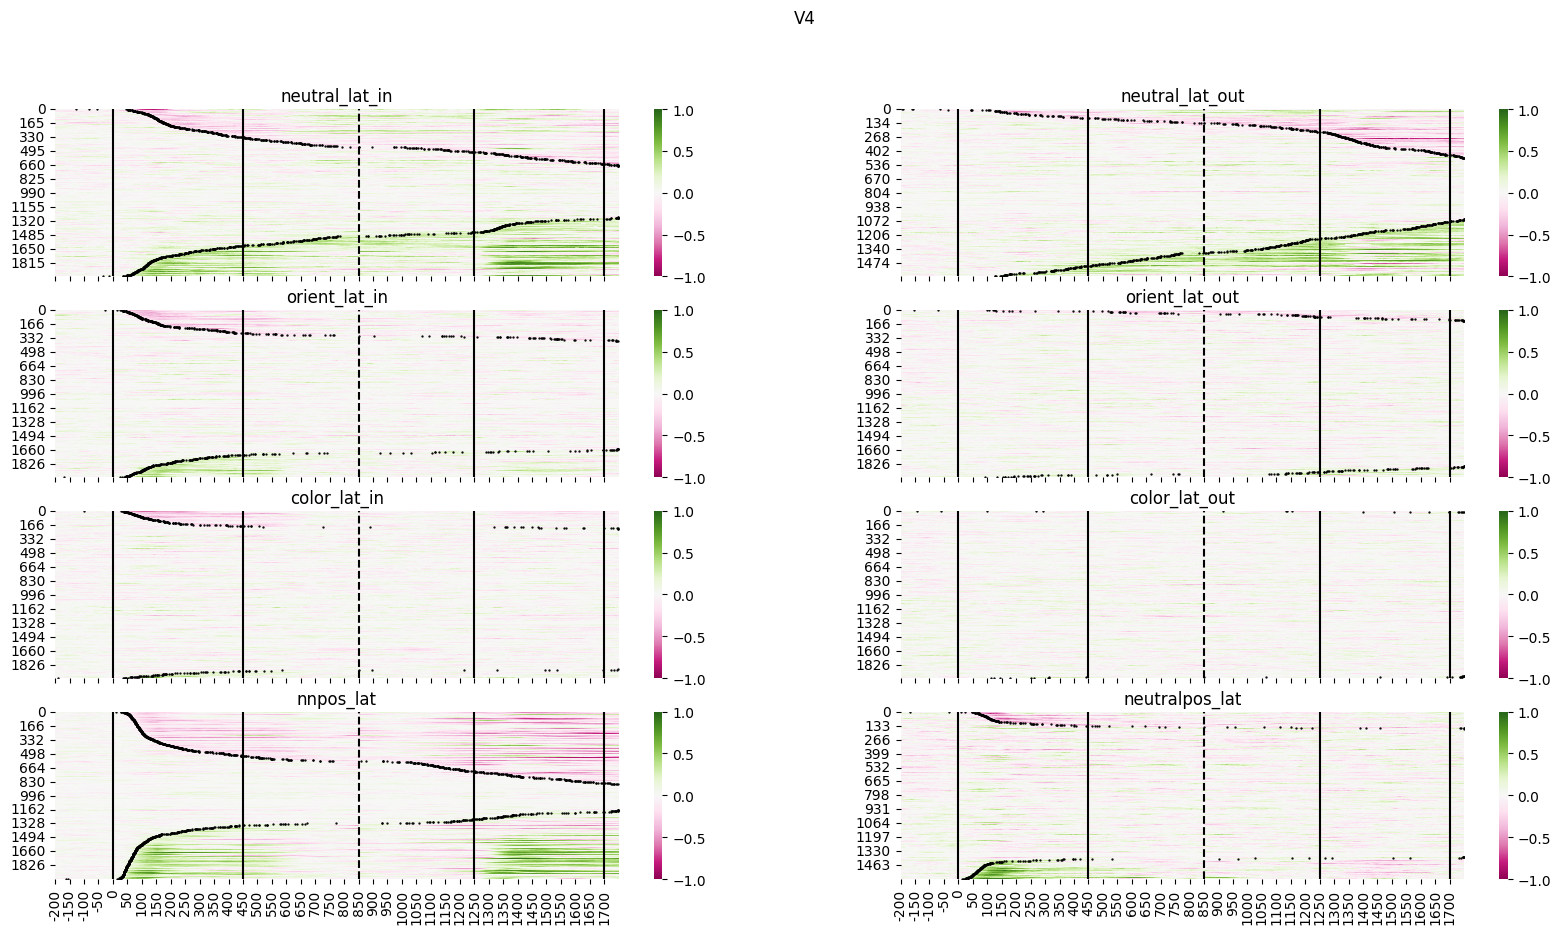

In [5]:
all_lat = {'lip':{},'pfc':{},'v4':{}}
for area in ['v4']:
    df_sel=df_fr_all[area]
    df_sel_in =  df_sel[df_sel['mean_fr_in']>0]
    df_sel_out = df_sel[df_sel['mean_fr_out']>0]


    # if save:
    #     savepath = path + f"/{area}_selectivity.{save_format}"
    #     fig.savefig(savepath,format=save_format,bbox_inches="tight")

In [129]:
df=df_fr_all['v4']

In [130]:
max_len=400
d2_o1_in = df['d2_o1_in'].values.tolist()
d2_o1_in = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in d2_o1_in]
d2_o1_in = np.array(d2_o1_in)

d2_o5_in = df['d2_o5_in'].values.tolist()
d2_o5_in = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in d2_o5_in]
d2_o5_in = np.array(d2_o5_in)

d2_c1_in = df['d2_c1_in'].values.tolist()
d2_c1_in = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in d2_c1_in]
d2_c1_in = np.array(d2_c1_in)

d2_c5_in = df['d2_c5_in'].values.tolist()
d2_c5_in = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in d2_c5_in]
d2_c5_in = np.array(d2_c5_in)

/tmp/ipykernel_28805/2768940150.py:6: RuntimeWarning: Mean of empty slice
  d2o1 = np.nanmean(d2_o1_in,axis=1)
/tmp/ipykernel_28805/2768940150.py:7: RuntimeWarning: Mean of empty slice
  d2o5 = np.nanmean(d2_o5_in,axis=1)


0.21232432750577324
66
0.4370860927152318


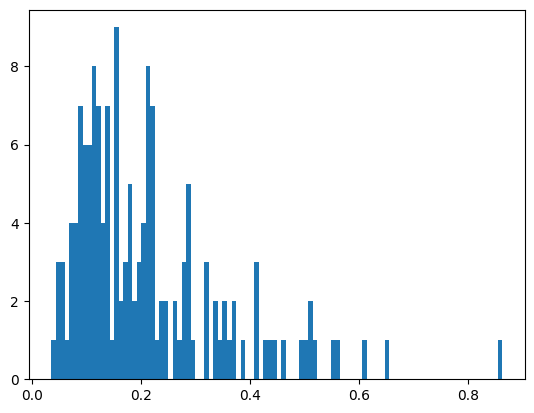

In [224]:
pval=[]
##TODO: Probar wilconxon AND ANOVA to study the interaction of color and direction
for i in range(len(d2_o5_in)):
    pval.append(stats.ttest_ind(d2_o5_in[i], d2_o1_in[i],nan_policy='omit')[1])
pval=np.array(pval)

d2o1 = np.nanmean(d2_o1_in,axis=1)
d2o5 = np.nanmean(d2_o5_in,axis=1)
masknan = pval<0.01#np.logical_and(~np.isnan(d2o1),~np.isnan(d2o5))
abs_dif = np.abs((d2o1[masknan]-d2o5[masknan])/(d2o5[masknan]+d2o1[masknan]))
_=plt.hist(abs_dif,bins=100)
print(np.nanmean(abs_dif))
print(np.nansum(abs_dif>0.2))
print(np.nansum(abs_dif>0.2)/len(abs_dif))
